In [1]:
from transformers import AutoTokenizer, AutoModel, DataCollatorWithPadding
from transformers.modeling_outputs import SequenceClassifierOutput
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader
from torch.optim import AdamW, SGD
import torch

# Define model

In [2]:
checkpoint = "distilbert-base-uncased"

In [3]:
class Lambda(nn.Module):
    """A neural network layer that applies the specified function to its inputs."""
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x): return self.func(x)

In [4]:
def print_shape(x):
    print(x.shape)
    return x

def flatten(x):
    return x.view(x.shape[0], -1)

In [5]:
class RegressiveTransformer(nn.Module):
    TRANSFORMER_HIDDEN_SIZE = 768
    LINEAR_HIDDEN_SIZE = 500
    
    def __init__(self, num_tokens):
        super(RegressiveTransformer, self).__init__()
        self.base_model = AutoModel.from_pretrained(checkpoint)
        self.head = nn.Sequential(
            nn.Linear(self.TRANSFORMER_HIDDEN_SIZE, self.LINEAR_HIDDEN_SIZE),
            nn.ReLU(),
            nn.Linear(self.LINEAR_HIDDEN_SIZE, 1),
            Lambda(flatten),
            nn.Linear(num_tokens, 1),
            Lambda(flatten),
            Lambda(lambda x: x.squeeze())
        )
        self.loss = nn.MSELoss()
        
    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.base_model(input_ids, attention_mask=attention_mask)
        outputs = self.head(outputs[0])
        
        loss = None
        if labels is not None:
            loss = self.loss(outputs, labels)
    
        return SequenceClassifierOutput(loss=loss, logits=outputs)
    
    def freeze_base(self, freeze=True):
        for param in self.base_model.parameters():
            param.requires_grad = not freeze

# Test Model

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

raw_inputs = [
    "Left left left",
    "Right right right",
]
inputs = tokenizer(raw_inputs, padding=True, truncation=True, return_tensors="pt")

In [ ]:
inputs

In [ ]:
num_tokens = inputs['input_ids'].shape[1]

In [ ]:
inputs['input_ids'].shape

In [ ]:
model = RegressiveTransformer(num_tokens)

outputs = model(**inputs)
print(outputs)
print(outputs.logits.size())

Alright, we started with a batch of our sentence inputs, and we now have a continuous value for each.

Next, we need some data to fine tune on.

# Data

- Alright, we have a csv with all this data
- We also need to bring in the media bias ratings

- Then we want a way to read from the CSV and generate as much training data as we want
- Let's look at some of the other data sets to look at the rough size that you'd use to finetune BERT
  - Looks like 10-100k rows

- I could preprocess this into a new CSV file with all the info condensed
- Validation set should include articles from publications not in the train set
- Evaluate accuracy based on whether predicted result is within delta of labelled value
  - Maybe delta starts pretty large, say 0.5 or 0.25

What data set do we need to establish the pipeline?

CSV of article => rating

# Prep training data

Next steps:

- [ ] Prepare real data CSV
- [x] Set up DataLoaders
- [ ] Prepare LR scheduler
- [ ] Set up training loop
- [ ] Set up evaluation

In [6]:
import pandas as pd
from datasets import Dataset

In [11]:
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [12]:
data_train = Dataset.from_csv('data/train.csv')
data_valid = Dataset.from_csv('data/valid.csv')

Using custom data configuration default-066b19bb8c079d37
Reusing dataset csv (/Users/rohanmitchell/.cache/huggingface/datasets/csv/default-066b19bb8c079d37/0.0.0)
Using custom data configuration default-b3e6650d3374ad52
Reusing dataset csv (/Users/rohanmitchell/.cache/huggingface/datasets/csv/default-b3e6650d3374ad52/0.0.0)


In [13]:
def encode(sample):
    return tokenizer(sample['text'], padding=True, truncation=True)

In [14]:
data_train = data_train.map(encode, batched=True)
data_valid = data_valid.map(encode, batched=True)

Loading cached processed dataset at /Users/rohanmitchell/.cache/huggingface/datasets/csv/default-066b19bb8c079d37/0.0.0/cache-eac78cac562f6e4b.arrow


  0%|          | 0/1 [00:00<?, ?ba/s]

In [16]:
data_train = data_train.remove_columns(['text'])
data_valid = data_valid.remove_columns(['text'])
data_train = data_train.rename_column('rating', 'labels')
data_valid = data_valid.rename_column('rating', 'labels')
data_train.set_format('torch')
data_valid.set_format('torch')

In [17]:
data_train[0]

{'labels': tensor(-1.),
 'input_ids': tensor([ 101, 2516, 2187, 1012, 3720, 2187,  102,    0,    0,    0,    0]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0])}

In [18]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
train_dataloader = DataLoader(
    data_train,
    shuffle=True,
    batch_size=8,
    collate_fn=data_collator
)
eval_dataloader = DataLoader(
    data_valid,
    batch_size=8,
    collate_fn=data_collator
)

In [19]:
num_tokens = data_train['input_ids'].shape[1]

# Train

In [66]:
model = RegressiveTransformer(num_tokens)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [67]:
model.freeze_base()

In [80]:
#optimizer = AdamW(model.parameters(), lr=0.0001)
optimizer = SGD(model.parameters(), lr=0.00001)

In [69]:
all_results = []

In [86]:
for i in range(100):
    for batch in train_dataloader:
        results = model(**batch)
        all_results.append([r for _, r in sorted(zip(batch['labels'], model(**batch).logits.tolist()))])
        results.loss.backward()
        optimizer.step()

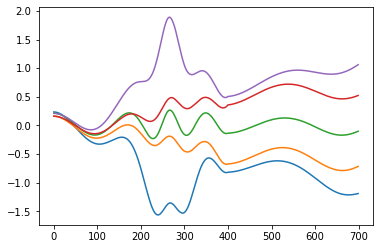

In [87]:
import matplotlib.pyplot as plt
plt.plot(all_results)
plt.show()

In [88]:
[r for _, r in sorted(zip(batch['labels'], model(**batch).logits.tolist()))]

[-1.1870756149291992,
 -0.7102802395820618,
 -0.09736479818820953,
 0.5271592736244202,
 1.0671522617340088]